<a href="https://colab.research.google.com/github/flxshr/BP22---Challenge/blob/main/BP22_Challenge_FelixSchrock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bill Perkins (GASTRADER) Twitter Challenge

Submitted by: 
- Name: Felix Schrock
- Occupation: Data Science Graduate Student
- Email: felix.schrock@studbocconi.it
- GitHub: https://github.com/flxshr/BP22---Challenge
- LinkedIN: https://www.linkedin.com/in/felix-schrock-a7a81812a/



## Data Imports & Function Definitions

In [1]:
# Upload the datasets to COLAB from Dropbox Folder
!wget -O population_data.csv https://www.dropbox.com/s/zlrh7amwivugmsv/Population%20Data.csv?dl=0
!wget -O temperature_data.csv https://www.dropbox.com/s/b4ikek6ic0yoe2r/Temperature%20Data.csv?dl=0

--2021-07-01 01:13:34--  https://www.dropbox.com/s/zlrh7amwivugmsv/Population%20Data.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.18, 2620:100:6032:18::a27d:5212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/zlrh7amwivugmsv/Population%20Data.csv [following]
--2021-07-01 01:13:35--  https://www.dropbox.com/s/raw/zlrh7amwivugmsv/Population%20Data.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdbf725ff28909fdcea62d99fba.dl.dropboxusercontent.com/cd/0/inline/BRfTunbuj3b5TNXtBEJK8OKkPtv5A1VBB3ibfXgN84If5sh--fycW9eEpB7orVL9-CBLtZSsMZix72QOWZYTRD11zNoWdo3lcBd22D9Y-f53Yrv6V6WmiP1s1k_DpPQag6-TU83sVmyFz_z28FRbWiPD/file# [following]
--2021-07-01 01:13:35--  https://ucdbf725ff28909fdcea62d99fba.dl.dropboxusercontent.com/cd/0/inline/BRfTunbuj3b5TNXtBEJK8OKkPtv5A1VBB3ibfXgN84If5sh--fycW9e

In [2]:
import os, sys, re
import numpy as np
import pandas as pd
# adjust reporting in pandas: max 10 rows and two-digit precision
pd.options.display.float_format = "{:,.2f}".format

from collections import defaultdict 

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook


import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# install pdpbox for partial dependency visualization
!pip install pdpbox &> /dev/null
from pdpbox import info_plots, pdp

plt.style.use('seaborn-whitegrid')

import statsmodels.tsa
from statsmodels.tsa.seasonal import seasonal_decompose

# Ignore useless some warnings
import warnings
warnings.simplefilter(action="ignore")

In [3]:
# Working on Colab

# Create a function to save figures to a desired local folder
FIGURE_FOLDER = "Figures"
FIGURE_PATH = os.path.join(".",FIGURE_FOLDER)
os.makedirs(FIGURE_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(FIGURE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Part 1: Data Exploration & Time Series Creation

In [4]:
# load population dataframe
pop_df = pd.read_csv("population_data.csv")

# load temperature dataframe
temp_df = pd.read_csv("temperature_data.csv")

In [5]:
pop_df.head(3)

,City,State,population,Lon,Lat
0,Henderson,Nevada,260068,-115.04,36.01
1,Manchester,New Hampshire,109830,-71.44,42.98
2,Elizabeth,New Jersey,125660,-74.19,40.67


In [6]:
pop_df.tail(3)

,City,State,population,Lon,Lat
282,Fort Lauderdale,Florida,168528,-80.14,26.14
283,Pompano Beach,Florida,101617,-80.13,26.24
284,West Palm Beach,Florida,101043,-80.13,26.75


In [7]:
temp_df.head(3)

,name,country_name,country_code,continent,station_code,location_date,temp_mean_c,temp_min_c,temp_max_c
0,Atlanta,UnitedStates,USA,North America,KATL,4/20/2021,17.49,12.20,23.30
1,Windsor Locks,UnitedStates,USA,North America,KBDL,4/20/2021,13.89,3.90,22.20
2,Nashville,UnitedStates,USA,North America,KBNA,4/20/2021,15.18,6.70,23.30


In [8]:
temp_df.tail(3)

,name,country_name,country_code,continent,station_code,location_date,temp_mean_c,temp_min_c,temp_max_c
89216,Raleigh/Durham,UnitedStates,USA,North America,KRDU,1/1/2015,3.29,-4.40,10.60
89217,Pittsburgh,UnitedStates,USA,North America,KPIT,1/1/2015,-2.57,-6.70,1.70
89218,Phoenix/Sky HRBR,UnitedStates,USA,North America,KPHX,1/1/2015,4.35,1.70,7.20


__Comment:__ The head and tail of each dataframe are consistent.

Next, we focus on duplicate location entries. 

In [9]:
pop_dup_cities = pop_df.loc[pop_df["City"].duplicated()]["City"] # duplicated entries of the population dataframe
pop_dup_cities

136       Columbus
147         Aurora
170    Springfield
184      Rochester
186    Kansas City
188    Springfield
189       Columbia
206         Peoria
219       Richmond
250       Glendale
253       Pasadena
Name: City, dtype: object

In [10]:
pop_df.loc[pop_df["City"] == "Columbus"] #we have duplicate city names in different counties

,City,State,population,Lon,Lat
25,Columbus,Ohio,797434,-82.98,39.98
136,Columbus,Georgia,194107,-84.87,32.51


In [11]:
#get the unique city names of each dataframe
pop_locs = pop_df["City"].unique()
temp_locs = temp_df["name"].unique()

# City Names that appear in population and temperature dataframes
intersect_locs = pd.Series(list(set(pop_locs).intersection(set(temp_locs))))
intersect_locs

0            Seattle
1        Little Rock
2     Salt Lake City
3             Fresno
4      San Francisco
5          Baltimore
6             Denver
7            Buffalo
8             Dallas
9             Boston
10           Spokane
11          Columbus
12           Atlanta
13           Burbank
14        Washington
15       New Orleans
16        Pittsburgh
17         Las Vegas
18           Memphis
19         Nashville
20             Boise
21      Philadelphia
22           Houston
23          Portland
24          Richmond
25       Minneapolis
26       Los Angeles
dtype: object

__Comment:__ Before we can merge, we have to check whether any of the city names in this intersection, is duplicated in each of the dataframes we want to merge. 

In [12]:
# Check whether we have significantly more observations for one of these locations in the temperature data, ...
# this would indicate duplicated city names (e.g. Portland) in the time series dataframe
temp_df["name"].value_counts() 

Portland            4575
Phoenix/Sky HRBR    2302
Pittsburgh          2288
Seattle             2288
Philadelphia        2288
Sacramento/Execu    2288
St Louis/Lambert    2288
Little Rock         2288
Boston              2288
Nashville           2288
Raleigh/Durham      2288
Richmond            2288
Chicago O'Hare      2288
NYC/LaGuardia       2288
Memphis             2288
Windsor Locks       2288
Las Vegas           2288
Boise               2288
Spokane             2287
Columbus            2287
Minneapolis         2287
Houston             2287
Salt Lake City      2287
Albany              2287
Los Angeles         2287
Washington          2287
Wash DC/Dulles      2287
San Francisco       2287
Atlanta             2287
Burbank             2287
Fresno              2287
Covington           2287
Baltimore           2286
Detroit/Wayne       2286
Dallas              2286
Buffalo             2286
New Orleans         2286
Denver              2286
Name: name, dtype: int64

In [13]:
# create unique identifier for temperature dataframe
temp_df["uniq_loc"] = temp_df["name"] + "_" + temp_df["station_code"]

# get the first row of each unique location in a df (use first row, since for each city we have a time series of data)
duplicate_temp = temp_df.groupby("uniq_loc").agg("first")
duplicate_temp[(duplicate_temp["name"].duplicated())]

,name,country_name,country_code,continent,station_code,location_date,temp_mean_c,temp_min_c,temp_max_c
uniq_loc,,,,,,,,,
Portland_KPWM,Portland,UnitedStates,USA,North America,KPWM,4/20/2021,11.53,4.40,19.40


In [14]:
# we see that two Portlands are recorded in the temperature dateframe 
duplicate_temp.loc[duplicate_temp["name"] == "Portland"]

,name,country_name,country_code,continent,station_code,location_date,temp_mean_c,temp_min_c,temp_max_c
uniq_loc,,,,,,,,,
Portland_KPDX,Portland,UnitedStates,USA,North America,KPDX,4/20/2021,16.45,8.30,23.30
Portland_KPWM,Portland,UnitedStates,USA,North America,KPWM,4/20/2021,11.53,4.40,19.40


In [15]:
# check for which Portland we have a population estimate
pop_df.loc[pop_df["City"]=="Portland"]

,City,State,population,Lon,Lat
34,Portland,Oregon,593820,-122.65,45.54


__Comment:__ Lookup reveals that KPDX is the weather station at the Airport in Portland, Oregon. Thus we can discard the other Portland (Maine). 

In [16]:
# drop the rows that contain observations for Portland (Maine)
temp_df = temp_df.loc[~(temp_df["station_code"]=="KPWM")]

__Comment:__ Next focus on the duplicated locations in the population dataframe. (Here we do not have a time series format)

In [17]:
pop_df["uniq_loc"] = pop_df["City"] + "_" + pop_df["State"]

In [18]:
# duplicated locations in the population data (same city name, different counties)
duplicated_locs = pop_df[pop_df["City"].duplicated()]["City"]
duplicated_locs 

136       Columbus
147         Aurora
170    Springfield
184      Rochester
186    Kansas City
188    Springfield
189       Columbia
206         Peoria
219       Richmond
250       Glendale
253       Pasadena
Name: City, dtype: object

In [19]:
#get the duplicate locations that appear in both temperature and location dataframe 
pd.Series(list(set(duplicated_locs).intersection(set(intersect_locs))))

0    Columbus
1    Richmond
dtype: object

__Comment:__ We observe that for the same timeframe, we have varying number of observations in some cities. These are the missing values we will deal with later. 

In [20]:
# To figure out which Richmond and which Columbus we have data for: 
pop_df.loc[pop_df["City"].isin(["Columbus", "Richmond"])]

,City,State,population,Lon,Lat,uniq_loc
25,Columbus,Ohio,797434,-82.98,39.98,Columbus_Ohio
83,Richmond,Virginia,205533,-77.48,37.53,Richmond_Virginia
136,Columbus,Georgia,194107,-84.87,32.51,Columbus_Georgia
219,Richmond,California,105380,-122.36,37.95,Richmond_California


In [21]:
# we check which Columbus and which Richmond we find in the temperature data
temp_df.loc[temp_df["name"].isin(["Columbus", "Richmond"])][["name", "station_code"]].head(5)

,name,station_code
8,Columbus,KCMH
32,Richmond,KRIC
43,Richmond,KRIC
67,Columbus,KCMH
86,Columbus,KCMH


__Comment:__ Looking up the duplicate station codes reveals that KCMH is a weather station at the airport in Columbus, Ohio. KRIC corresponds to the weather station in Richmond, Virginia.


In [22]:
# drop the unmatched locations from the population dataframe
pop_df_clean = pop_df.loc[~pop_df["uniq_loc"].isin(["Richmond_California", "Columbus_Georgia"])].copy()

# assert that the intersection of city names in both dataframes only contains unique city names
#update the series
pop_locs_clean = pop_df_clean["City"].unique()

# City Names that appear in population and temperature dataframes
intersect_locs_2 = pd.Series(list(set(pop_locs_clean).intersection(set(temp_locs))))
duplicated_locs_2 = pop_df_clean[pop_df_clean["City"].duplicated()]["City"]

#get the locations that appear in temperature and location dataframe that are reported more than once!
assert len(pd.Series(list(set(duplicated_locs_2).intersection(set(intersect_locs_2))))) == 0 #no duplicated in the intersection!

__Comment:__ We have cleaned duplicate observations from each dataframe.

Next, we merge the dataframes. 

In [23]:
# since we established uniqueness, we can merge the dataframes based on the city names
known_pop_locs = pop_df_clean.loc[pop_df_clean["City"].isin(intersect_locs_2)].copy()
known_temp_locs = temp_df.loc[temp_df["name"].isin(intersect_locs_2)].copy()

# left merge since we have time series in temp_df (validate m:1)
comb_df = known_temp_locs.merge(known_pop_locs, how="left", left_on ="name", right_on = "City", validate="m:1")

In [24]:
comb_df.head(2)

,name,country_name,country_code,continent,station_code,location_date,temp_mean_c,temp_min_c,temp_max_c,uniq_loc_x,City,State,population,Lon,Lat,uniq_loc_y
0,Atlanta,UnitedStates,USA,North America,KATL,4/20/2021,17.49,12.20,23.30,Atlanta_KATL,Atlanta,Georgia,432427,-84.42,33.76,Atlanta_Georgia
1,Nashville,UnitedStates,USA,North America,KBNA,4/20/2021,15.18,6.70,23.30,Nashville_KBNA,Nashville,Tennessee,609644,-86.78,36.17,Nashville_Tennessee


In [25]:
comb_df.tail(2)

,name,country_name,country_code,continent,station_code,location_date,temp_mean_c,temp_min_c,temp_max_c,uniq_loc_x,City,State,population,Lon,Lat,uniq_loc_y
61752,Seattle,UnitedStates,USA,North America,KSEA,1/1/2015,0.95,-2.80,5.00,Seattle_KSEA,Seattle,Washington,620778,-122.35,47.62,Seattle_Washington
61753,Pittsburgh,UnitedStates,USA,North America,KPIT,1/1/2015,-2.57,-6.70,1.70,Pittsburgh_KPIT,Pittsburgh,Pennsylvania,307484,-79.98,40.44,Pittsburgh_Pennsylvania


__Comment:__ Merging worked without problems!

In [26]:
# drop unwanted columns
comb_df = comb_df.drop(["name", "country_name", "continent"], axis=1)

cities = comb_df["City"].unique()


In [27]:
comb_df["City"].unique()

array(['Atlanta', 'Nashville', 'Boise', 'Boston', 'Buffalo', 'Burbank',
       'Baltimore', 'Columbus', 'Los Angeles', 'Washington', 'Denver',
       'Dallas', 'Fresno', 'Spokane', 'Houston', 'Las Vegas',
       'Little Rock', 'Memphis', 'Minneapolis', 'New Orleans', 'Portland',
       'Philadelphia', 'Pittsburgh', 'Richmond', 'Seattle',
       'San Francisco', 'Salt Lake City'], dtype=object)

In [28]:
#check for missing values in dataframe as is!
comb_df[["temp_max_c", "temp_min_c", "temp_mean_c"]].isna().sum()

temp_max_c     0
temp_min_c     0
temp_mean_c    0
dtype: int64

__Comment:__ There are no missing values in the recorded dates. However, not all dates between 1/1/2015 and 4/20/2021 have been recorded as we have seen above in the value counts!

In [29]:
# create a dataframe with all dates between 1/1/2015 and 4/20/2021
dates = pd.DataFrame(pd.date_range(start= "1/1/2015", end= "4/20/2021", freq='D')).rename({0:"date"}, axis=1)
date_list = list(dates["date"].astype(str))

# use default dict as basis for dataframe with index of type [Level 0: City, Level 1: Date Range]
date_def_dict = defaultdict(list)
#create the base for the new dataframe with all date entries

for city in cities:
  date_def_dict[city] = date_list

#create the new dateframe base from the dictionary
date_df = pd.DataFrame.from_dict(date_def_dict, orient="index").stack().to_frame()
# to break out the lists into columns
date_df = pd.DataFrame(date_df[0].values.tolist(), index=date_df.index)

#rename
date_df.rename({0:"Date"},axis=1, inplace=True)
date_df.head(2)

Date
Atlanta 0  2015-01-01
        1  2015-01-02

In [30]:
date_df.tail(2)

Date
Salt Lake City 2300  2021-04-19
               2301  2021-04-20

In [31]:
# assert that for each known city in the combined dateframe, we have every day as an entry
assert date_df.shape[0] == (len(comb_df["uniq_loc_y"].unique()) * len(date_list))

In [32]:
# rename date df
date_df = date_df.reset_index().drop("level_1", axis=1)
date_df = date_df.rename({"level_0": "City"},axis=1)

date_df["Date"] = pd.to_datetime(date_df["Date"]).dt.strftime('%Y/%m/%d')

comb_df["location_date"] = pd.to_datetime(comb_df["location_date"])
comb_df["location_date"] = comb_df["location_date"].dt.strftime('%Y/%m/%d')

In [33]:
# since this assertion is false, we know that the original temperature dataframe has missing dates in each cities
len(set(date_df["Date"])) == len(set(comb_df["location_date"]))

False

In [34]:
# assert that columns City and Date uniquely identify the rows in the base dataframe date_df
assert date_df.set_index(["Date", "City"]).index.is_unique
# assert that columns "location_date" and "City" uniquely identify the rows in the temp / population dataframe
assert comb_df.set_index(['location_date','City']).index.is_unique

full_df = date_df.merge(comb_df, how="left", left_on=["Date", "City"], right_on=["location_date", "City"], validate = "1:m")

# assert that the new dataframe has the as many rows as we have unique cities * date range
assert full_df.shape[0] == len(cities) * len(pd.date_range(start= "1/1/2015", end= "4/20/2021", freq='D'))

full_df.head(2)

,City,Date,country_code,station_code,location_date,temp_mean_c,temp_min_c,temp_max_c,uniq_loc_x,State,population,Lon,Lat,uniq_loc_y
0,Atlanta,2015/01/01,USA,KATL,2015/01/01,6.76,0.00,13.90,Atlanta_KATL,Georgia,"432,427.00",-84.42,33.76,Atlanta_Georgia
1,Atlanta,2015/01/02,USA,KATL,2015/01/02,8.12,6.70,9.40,Atlanta_KATL,Georgia,"432,427.00",-84.42,33.76,Atlanta_Georgia


In [35]:
full_df.tail(2)

,City,Date,country_code,station_code,location_date,temp_mean_c,temp_min_c,temp_max_c,uniq_loc_x,State,population,Lon,Lat,uniq_loc_y
62152,Salt Lake City,2021/04/19,USA,KSLC,2021/04/19,11.95,7.20,18.30,Salt Lake City_KSLC,Utah,"189,899.00",-111.93,40.78,Salt Lake City_Utah
62153,Salt Lake City,2021/04/20,USA,KSLC,2021/04/20,8.08,1.70,13.90,Salt Lake City_KSLC,Utah,"189,899.00",-111.93,40.78,Salt Lake City_Utah


__Comment:__ After merging the dataframes with unique locations for each date in specified period, we can now study whether we have missing values.

In [36]:
full_df[["temp_mean_c", "temp_min_c", "temp_max_c"]].isna().sum()

# we see that now we are missing 400 observations

temp_mean_c    400
temp_min_c     400
temp_max_c     400
dtype: int64

In [37]:
# create dataframe with missing values only
full_na = full_df.loc[full_df["temp_mean_c"].isna()]
#indicator to whether day with missing value is a weekday
full_na['WEEKDAY'] = ((pd.DatetimeIndex(full_na.index).dayofweek) // 5 == 1).astype(float)
full_na["WEEKDAY"].sum()

# we observe that the all missing values occur on weekdays

0.0

In [38]:
# we check whether the missing dates are the same for each location
full_na.groupby("City").agg("count")["Date"]

City
Atlanta           15
Baltimore         16
Boise             14
Boston            14
Buffalo           16
Burbank           15
Columbus          15
Dallas            16
Denver            16
Fresno            15
Houston           15
Las Vegas         14
Little Rock       14
Los Angeles       15
Memphis           14
Minneapolis       15
Nashville         14
New Orleans       16
Philadelphia      14
Pittsburgh        14
Portland          15
Richmond          14
Salt Lake City    15
San Francisco     15
Seattle           14
Spokane           15
Washington        15
Name: Date, dtype: int64

In [39]:
full_na.loc[full_na["City"]=="Pittsburgh"]

,City,Date,country_code,station_code,location_date,temp_mean_c,temp_min_c,temp_max_c,uniq_loc_x,State,population,Lon,Lat,uniq_loc_y,WEEKDAY
50710,Pittsburgh,2015/03/08,NaN,NaN,NaN,nan,nan,nan,NaN,NaN,nan,nan,nan,NaN,0.00
50948,Pittsburgh,2015/11/01,NaN,NaN,NaN,nan,nan,nan,NaN,NaN,nan,nan,nan,NaN,0.00
51081,Pittsburgh,2016/03/13,NaN,NaN,NaN,nan,nan,nan,NaN,NaN,nan,nan,nan,NaN,0.00
51319,Pittsburgh,2016/11/06,NaN,NaN,NaN,nan,nan,nan,NaN,NaN,nan,nan,nan,NaN,0.00
51445,Pittsburgh,2017/03/12,NaN,NaN,NaN,nan,nan,nan,NaN,NaN,nan,nan,nan,NaN,0.00
51633,Pittsburgh,2017/09/16,NaN,NaN,NaN,nan,nan,nan,NaN,NaN,nan,nan,nan,NaN,0.00
51683,Pittsburgh,2017/11/05,NaN,NaN,NaN,nan,nan,nan,NaN,NaN,nan,nan,nan,NaN,0.00
51809,Pittsburgh,2018/03/11,NaN,NaN,NaN,nan,nan,nan,NaN,NaN,nan,nan,nan,NaN,0.00
52047,Pittsburgh,2018/11/04,NaN,NaN,NaN,nan,nan,nan,NaN,NaN,nan,nan,nan,NaN,0.00
52173,Pittsburgh,2019/03/10,NaN,NaN,NaN,nan,nan,nan,NaN,NaN,nan,nan,nan,NaN,0.00


__Comment:__ We observe that first and last missing values for each city are always sundays. That is, on Sundays, we often do not have observations. 

To overcome the problem of missing values, we could take at least __two paths__.

__FIRST PATH:__ Since we have coordinate data, we could calculate whether there is a weather station closeby (e.g. in a given Haversine radius) for the station with the missing value and take the reported temperatures for that station. 

- This strategy is not applicable given the data, as we have reason to expect that the locations of interest are not close to each other (since we have only 27 cities in the USA). Moreover, we have seen that the missing values are reported on the same days, which increases chances of being a successful strategy drastically.

__SECOND PATH:__ For a given location, we can interpolate the weather based on the temperature before the missing value day and after the missing value day. We have seen above that there is usually only one missing value in a given timeframe of some days. To close this small gap in observations, we can use different interpolation methods.

- This strategy appears sensible, since the missing value day is usually only one day and it can be expected that the temperature on the missing value day can be calculated as mean of the (t-1), (t+1) values. 


__OTHER PATHS:__ Interpolation could also be done with predictive models (Regression models or HMM). We start with the simpler method of the second path.


In [40]:
full_df = full_df.rename({"uniq_loc_y":"Unique_Location"}, axis=1)
full_df = full_df.rename(columns=str.lower)

In [41]:
full_df.head()

,city,date,country_code,station_code,location_date,temp_mean_c,temp_min_c,temp_max_c,uniq_loc_x,state,population,lon,lat,unique_location
0,Atlanta,2015/01/01,USA,KATL,2015/01/01,6.76,0.00,13.90,Atlanta_KATL,Georgia,"432,427.00",-84.42,33.76,Atlanta_Georgia
1,Atlanta,2015/01/02,USA,KATL,2015/01/02,8.12,6.70,9.40,Atlanta_KATL,Georgia,"432,427.00",-84.42,33.76,Atlanta_Georgia
2,Atlanta,2015/01/03,USA,KATL,2015/01/03,11.15,8.90,16.10,Atlanta_KATL,Georgia,"432,427.00",-84.42,33.76,Atlanta_Georgia
3,Atlanta,2015/01/04,USA,KATL,2015/01/04,14.28,6.70,17.80,Atlanta_KATL,Georgia,"432,427.00",-84.42,33.76,Atlanta_Georgia
4,Atlanta,2015/01/05,USA,KATL,2015/01/05,5.05,1.10,8.90,Atlanta_KATL,Georgia,"432,427.00",-84.42,33.76,Atlanta_Georgia


In [42]:
full_df.isna().any()

city               False
date               False
country_code        True
station_code        True
location_date       True
temp_mean_c         True
temp_min_c          True
temp_max_c          True
uniq_loc_x          True
state               True
population          True
lon                 True
lat                 True
unique_location     True
dtype: bool

__Comment:__ Below we interpolate the data. We use forward and bi-directional fill methods for interpolation. Since we have different cities in the same dataframe in "panel" data format, we need to check whether the first or last values are missing for each city. If they are not missing, we can be certain that we only interpolate for a a given cities and that we do not take for example the last observation of city X and the second observations of city Y to linearly interpolate the first observation of city Y.

In [43]:
# check the first observation of each city 
assert full_df.groupby("unique_location").agg("first").isna().any().sum() == 0
# check the last observation
assert full_df.groupby("unique_location").agg("last").isna().any().sum() == 0

In [44]:
full_cities = full_df["city"].unique()

# string columns to interpolate by padding
string_cols = ["station_code", "state", "unique_location"]

for col in string_cols:
  full_df[col].interpolate(method="pad",
                          limit_direction= "forward",
                          axis=0, 
                          inplace=True)

In [45]:
# convert numeric columns from string format to float format.
numeric_cols = ["temp_mean_c", "temp_min_c", "temp_max_c", "population", "lon", "lat"]

full_df[numeric_cols] = full_df[numeric_cols].astype(float)

for col in numeric_cols:
  full_df[col].interpolate(method="linear", #use linear interpolation, since the lag length is just a single day
                      limit_direction='both',
                      axis=0, 
                      inplace=True)

### Population Weighted Time Series: 

We employ a simple weighting scheme. We calculate the total population of our sample and the use that value to normalize the population for each city. 

Certainly, more advanced weighting schemes could be employed, but due to the time constraint and the limited covariates in the data, we do not explore other weighting schemes. 

In [46]:
full_df["population"].describe()

count      62,154.00
mean      712,919.93
std       748,894.86
min       104,092.00
25%       261,025.00
50%       593,820.00
75%       652,050.00
max     3,819,702.00
Name: population, dtype: float64

In [47]:
# get the city population for each city 
city_pop = full_df.groupby("city").agg(["first"])["population"]

# calculate the sum of the total population (for unique cities)
total_sample_pop = city_pop["first"].sum()

# classic weighting scheme (city pop / totalpop in sample) 
full_df["classic_weight"] = full_df["population"] / total_sample_pop

In [48]:
# select columns which we want to weight by the population weight
to_weight = ["temp_mean_c",	"temp_min_c",	"temp_max_c"]

for col in to_weight:
  full_df["class_weight" + "_" + col] = full_df[col] * full_df["classic_weight"]

weighted_series = full_df.groupby("date").agg({"classic_weight":"sum", "class_weight_temp_mean_c":"sum", "class_weight_temp_min_c":"sum", "class_weight_temp_max_c":"sum"}).rename({"classic_weight":"classic_weight_sum"}, axis=1)

In [49]:
# we observe that the classic weight is 1 for each day, which is to be expected
weighted_series.head(2)

,classic_weight_sum,class_weight_temp_mean_c,class_weight_temp_min_c,class_weight_temp_max_c
date,,,,
2015/01/01,1.00,2.95,-1.15,7.07
2015/01/02,1.00,4.89,1.16,8.74


In [50]:
weighted_series = weighted_series.asfreq(freq="D")

## Part 2: Visualization Use Cases

__Visualization Use Case #1:__

"Someone who wants to know how the temperature compares to the seasonal average as well as high and low cases."



Saving figure three_months_trends with ma


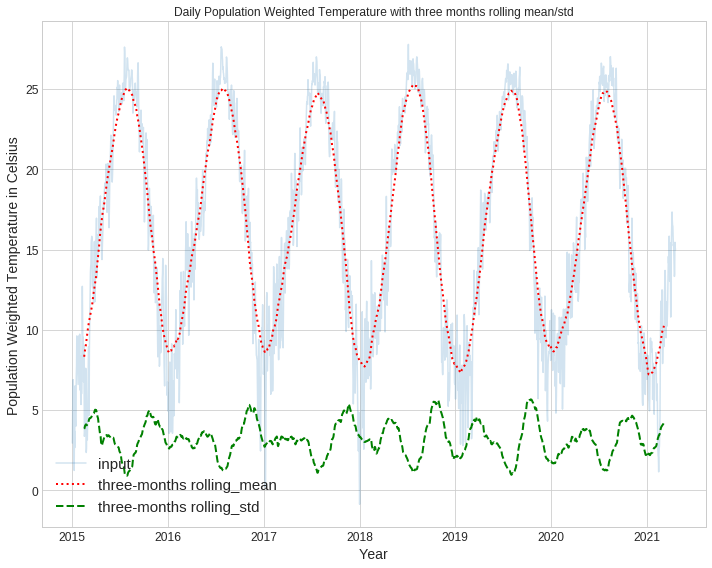

In [51]:
# grab the mean observations
mean_df = weighted_series["class_weight_temp_mean_c"]

rolling = mean_df.rolling(90, center =True) #rolling window of past 90 days (seasons)

data = pd.DataFrame({"input":mean_df,
                     "three-months rolling_mean": rolling.mean(),
                     "three-months rolling_std":rolling.std()})

fig, ax = plt.subplots(1,1, figsize=(10,8))
ax.plot(mean_df.index, data["input"],"-" , alpha=0.2)
ax.plot(mean_df.index, data["three-months rolling_mean"], ":", color="red", linewidth=2)
ax.plot(mean_df.index, data["three-months rolling_std"], "--", color="green", linewidth=2)
ax.legend(["input", "three-months rolling_mean", "three-months rolling_std"],  prop={'size': 15})
ax.set_title("Daily Population Weighted Temperature with three months rolling mean/std")
ax.set_xlabel("Year")
ax.set_ylabel("Population Weighted Temperature in Celsius")
save_fig("three_months_trends with ma")

The 90 day rolling average behaves in similar fashion as the original input data. The 90 day rolling standard deviation tends to increase before the wintertime. Next, we look at a yearly rolling window.

Saving figure one_year_trends with ma


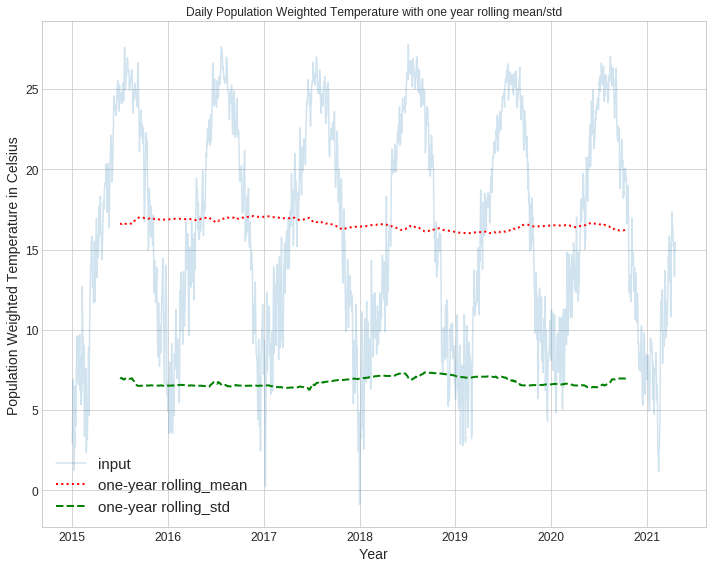

In [52]:
rolling = mean_df.rolling(365, center =True) #rolling window of past 365 days (yearly)

data = pd.DataFrame({"input":mean_df,
                     "one-year rolling_mean": rolling.mean(),
                     "one-year rolling_std":rolling.std()})

fig, ax = plt.subplots(1,1, figsize=(10,8))
ax.plot(mean_df.index, data["input"],"-" , alpha=0.2)
ax.plot(mean_df.index, data["one-year rolling_mean"], ":", color="red", linewidth=2)
ax.plot(mean_df.index, data["one-year rolling_std"], "--", color="green", linewidth=2)
ax.legend(["input", "one-year rolling_mean", "one-year rolling_std"],  prop={'size': 15})
ax.set_title("Daily Population Weighted Temperature with one year rolling mean/std")
ax.set_xlabel("Year")
ax.set_ylabel("Population Weighted Temperature in Celsius")
save_fig("one_year_trends with ma")

We observe, that the one year rolling mean is stable, which is sensible since temperatures are cyclical over one year.

Next, we use a more sophisticated plotting tool to discern the trend and seasonal component and residual. 

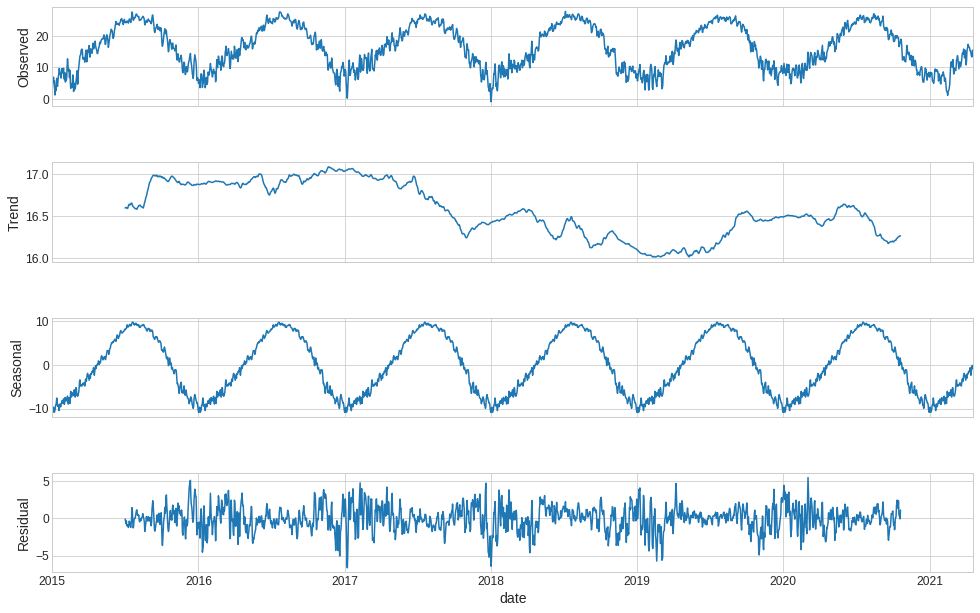

In [53]:
# create a seasonal decomposition plot of the mean temperature to understand what is driving the patterns in the data! 
mean_df = weighted_series["class_weight_temp_mean_c"]
seas_decomp_mean = seasonal_decompose(x = mean_df, model = "additive", freq=365) #set the frequency of the data to 365 days as we are dealing with years

g1 = seas_decomp_mean.plot() 
g1.set_figheight(10)
g1.set_figwidth(15)
g1.show()

The figure above shows the population weighted __mean__ temperature time series.

The plot is organized as follows. 
- first line is the observed time series
- second plot shows the trend component of the time series 
- third line shows the seasonal component (the cyclical pattern of the data once the trend has been removed)
- fourth line shows the residuals, i.e. the observed time series controlled for seasonal and trend component. 

Interpretation: 

- The trend component of temperature decreases from 17 towards 16 C over time.
- The seasonal component is driving the observed time series almost entirely. This is expected as temperature over a given year is cyclical. 
- We see that the residuals have a higher variance in the winter time compared to the summer time. This shows that the model is having the hardest time in explaining the variance in the data during the winter time, even after accounting for trend and seasonal component.

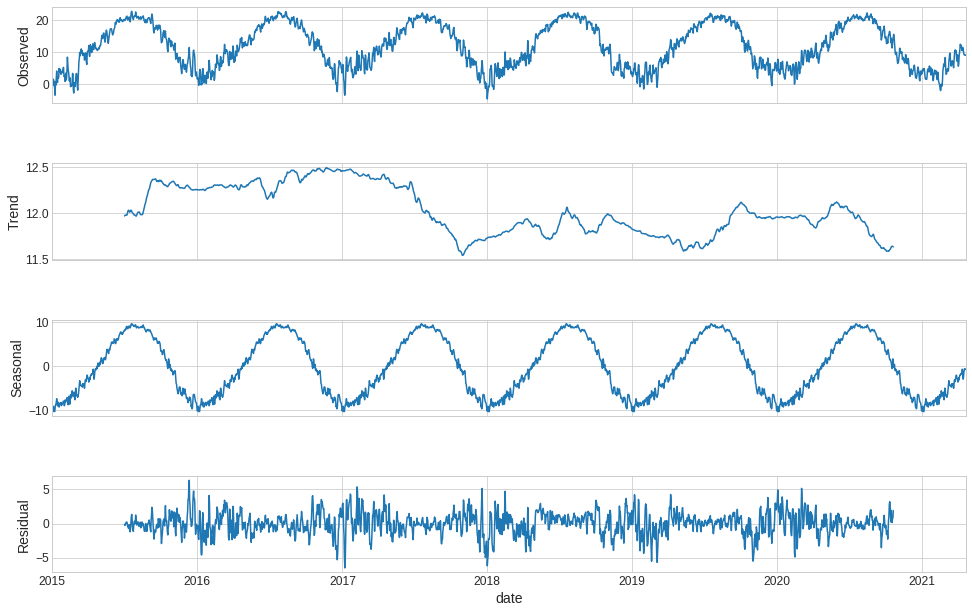

In [54]:
# create a seasonal decomposition plot of the min temperature to understand what is driving the patterns in the data! 
min_df = weighted_series["class_weight_temp_min_c"]
seas_decomp_min = seasonal_decompose(x = min_df, model = "additive", freq=365) #set the frequency of the data to 365 days as we are dealing with years

g2 = seas_decomp_min.plot() 
g2.set_figheight(10)
g2.set_figwidth(15)
g2.show()

Interpretation __min daily temp seasonal decomposition__ : 
- as expected, the seasonal component remains the same for plot of the daily min temperatures. 
- as expected, the trend component has lower values than the tend component for the mean plot (and the max plot, as we will see next!)
- the residuals again show the pattern that there is more variation in the data for the winter months, that remains unexplained.

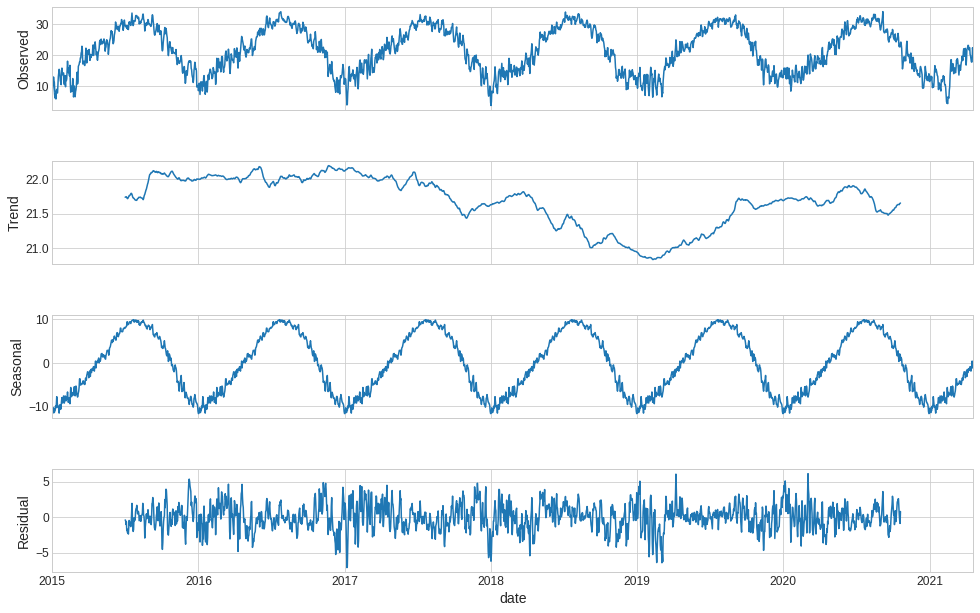

In [55]:
# create a seasonal decomposition plot of the max temperature to understand what is driving the patterns in the data! 
max_df = weighted_series["class_weight_temp_max_c"]
seas_decomp_max = seasonal_decompose(x = max_df, model = "additive", freq=365) #set the frequency of the data to 365 days as we are dealing with years

g3 = seas_decomp_max.plot() 
g3.set_figheight(10)
g3.set_figwidth(15)
g3.show()

Interpretation __max daily temp seasonal decomposition__ :

As expected the subplots of the max daily temp seasonal decomposition have similar trends as before. 

__Interestingly, the residual plot__ for the max daily temperature values are oscillating stronger throughout the year. 

__Visualization Use Case #2:__ 

"Someone who wants to view the monthly average, min and max." (monthly average, monthly min, monthly max)


In [56]:
monthly_df = weighted_series.groupby(pd.Grouper(freq='M')).agg({"class_weight_temp_mean_c":"mean",
                                                   "class_weight_temp_min_c":"min",
                                                   "class_weight_temp_max_c":"max"})
monthly_df.head()

,class_weight_temp_mean_c,class_weight_temp_min_c,class_weight_temp_max_c
date,,,
2015-01-31,6.42,-3.59,15.82
2015-02-28,6.36,-2.89,18.03
2015-03-31,11.99,-1.99,22.83
2015-04-30,15.94,8.58,24.74
2015-05-31,19.36,11.91,27.83


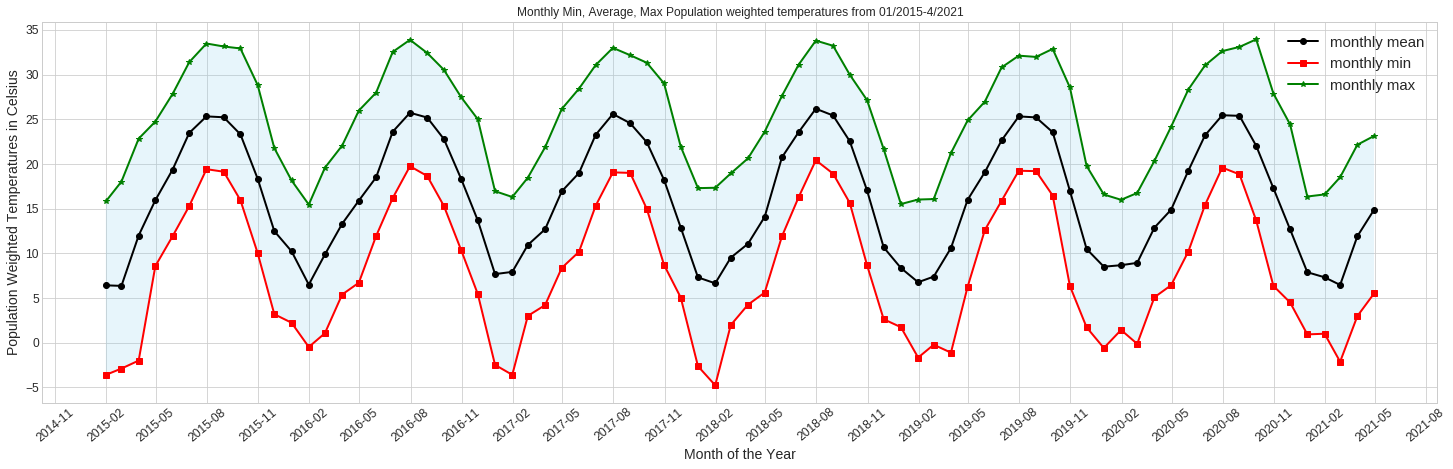

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(25,7))
ax.plot(monthly_df.index,monthly_df["class_weight_temp_mean_c"],linestyle='-', marker='o',color='black', linewidth=2)
ax.plot(monthly_df.index,monthly_df["class_weight_temp_min_c"],linestyle='-', marker = 's', color='red', linewidth=2)
ax.plot(monthly_df.index, monthly_df["class_weight_temp_max_c"],linestyle='-', marker='*',color='green', linewidth=2)
ax.fill_between(monthly_df.index,
                monthly_df["class_weight_temp_min_c"],
                monthly_df["class_weight_temp_max_c"],
                facecolor = "skyblue",
                alpha=0.2,
                interpolate=True)


# Major ticks every 3 months.
fmt_half_year = mdates.MonthLocator(interval=3)
ax.xaxis.set_major_locator(fmt_half_year)
ax.legend(["monthly mean", "monthly min","monthly max"],  prop={'size': 15})
ax.set_title("Monthly Min, Average, Max Population weighted temperatures from 01/2015-4/2021")
ax.set_ylabel("Population Weighted Temperatures in Celsius")
ax.set_xlabel("Month of the Year")
for label in ax.get_xticklabels():
        label.set_rotation(40)

__Visualization Use Case #3:__ 

"Someone who wants to graphically see what data is missing or projected."

Saving figure missing_vals_dayofweek


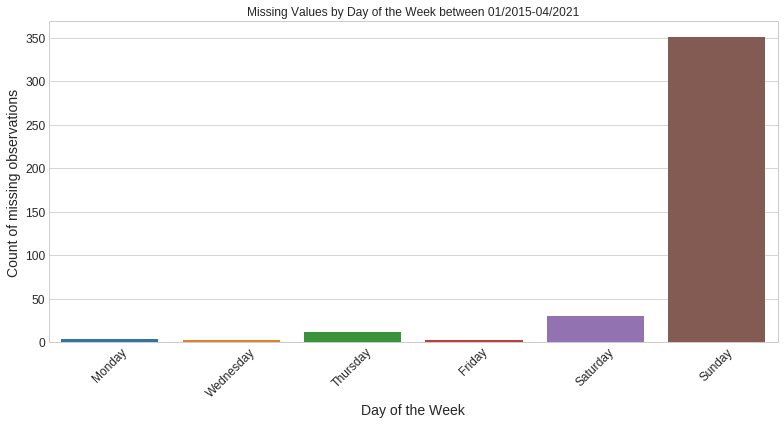

In [58]:
missing_df = full_df[["date","location_date","unique_location","lat", "lon"]]

#get missing observation dates
na_dates = missing_df[missing_df["location_date"].isna()].date

#convert them to weekdays 
days_of_week = pd.to_datetime(na_dates).dt.weekday

# plot the counts of the missing days
fig, ax = plt.subplots(1, 1, figsize=(11,6))
sns.countplot(days_of_week,ax=ax,)
ax.set_xticklabels(["Monday", "Wednesday","Thursday", "Friday", "Saturday", "Sunday"], rotation=45)
ax.set_xlabel("Day of the Week")
ax.set_ylabel("Count of missing observations")
ax.set_title("Missing Values by Day of the Week between 01/2015-04/2021")
save_fig("missing_vals_dayofweek")

__Comment:__ We see that by far the most missing values occur on sundays!

In [59]:
na_locs = missing_df[missing_df["location_date"].isna()]
na_locs = na_locs.groupby("unique_location").agg(["count"])["date"].reset_index().rename({"count":"num_missing"})

# append missing city counts to full df to check whether there are city with 0 missing values
full_df = full_df.merge(na_locs, how="left", left_on = "unique_location", right_on = "unique_location")
loc_df = full_df.groupby("uniq_loc_x").agg("first")

# check whether we have cities without any missing observations
print(loc_df["count"].unique())
print("We see that each city has at least 14 missing observations.")

[15 16 14]
We see that each city has at least 14 missing observations.


In [60]:
miss_locs = loc_df.groupby("unique_location").agg("first")[["city", "state", "lon", "lat", "station_code", "count"]].reset_index(drop=True)

#export the missing location counts to a .csv file
miss_locs.to_csv("Missing Location Counts.csv")
miss_locs
# this dataframe shows the unique count of missing observations for each location, with the corresponding station code

,city,state,lon,lat,station_code,count
0,Atlanta,Georgia,-84.42,33.76,KATL,15
1,Baltimore,Maryland,-76.61,39.30,KBWI,16
2,Boise,Idaho,-116.23,43.60,KBOI,14
3,Boston,Massachusetts,-71.02,42.33,KBOS,14
4,Buffalo,New York,-78.86,42.89,KBUF,16
5,Burbank,California,-118.32,34.19,KBUR,15
6,Columbus,Ohio,-82.98,39.98,KCMH,15
7,Dallas,Texas,-96.77,32.79,KDFW,16
8,Denver,Colorado,-104.88,39.76,KDEN,16
9,Fresno,California,-119.79,36.78,KFAT,15


In [61]:
#create a table that contains all interpolated values
missing_table = full_df[full_df["location_date"].isna()]

# Export this missing value table to a CSV in order to properly study it
missing_table.to_csv("Missing_Value_Table.csv")

missing_table.head()

,city,date,country_code,station_code,location_date,temp_mean_c,temp_min_c,temp_max_c,uniq_loc_x,state,population,lon,lat,unique_location,classic_weight,class_weight_temp_mean_c,class_weight_temp_min_c,class_weight_temp_max_c,count
66,Atlanta,2015/03/08,NaN,KATL,NaN,11.77,5.55,18.05,NaN,Georgia,"432,427.00",-84.42,33.76,Atlanta_Georgia,0.02,0.26,0.12,0.41,15
304,Atlanta,2015/11/01,NaN,KATL,NaN,16.57,14.15,20.00,NaN,Georgia,"432,427.00",-84.42,33.76,Atlanta_Georgia,0.02,0.37,0.32,0.45,15
437,Atlanta,2016/03/13,NaN,KATL,NaN,20.08,15.55,23.85,NaN,Georgia,"432,427.00",-84.42,33.76,Atlanta_Georgia,0.02,0.45,0.35,0.54,15
675,Atlanta,2016/11/06,NaN,KATL,NaN,16.06,11.15,21.95,NaN,Georgia,"432,427.00",-84.42,33.76,Atlanta_Georgia,0.02,0.36,0.25,0.49,15
801,Atlanta,2017/03/12,NaN,KATL,NaN,6.32,3.05,10.00,NaN,Georgia,"432,427.00",-84.42,33.76,Atlanta_Georgia,0.02,0.14,0.07,0.22,15
